# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%matplotlib inline

import datetime
import glob
from collections import deque

import gym
import numpy as np
import tqdm
import torch
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from unityagents import UnityEnvironment

from sac.sac import SAC
from sac.replay_memory import ReplayMemory

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
# env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# # get the default brain
# brain_name = env.brain_names[0]
# brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# # reset the environment
# env_info = env.reset(train_mode=True)[brain_name]

# # number of agents
# num_agents = len(env_info.agents)
# print('Number of agents:', num_agents)

# # size of each action
# action_size = brain.vector_action_space_size
# print('Size of each action:', action_size)

# # examine the state space 
# states = env_info.vector_observations
# state_size = states.shape[1]
# print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
# print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
# env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [2]:
##### MODIFY-ME #####
#reacher_binary_path = "Reacher_Windows_x86_64/Reacher.exe"
#reacher_binary_path = "Reacher_Linux_NoVis/Reacher.x86_64"
reacher_binary_path = "Reacher_Linux/Reacher.x86_64"

# Settings
replay_size = 100000
num_episodes = 500
num_init_random_steps = 1001
batch_size = 256
updates_per_step = 1
hidden_size = [128, 128]
adam_learning_rate = 3e-4
gamma = 0.9
tau = 0.005
initial_entropy = 0.2
automatic_entropy_tuning = True
target_update_interval = 1

eval_num_episodes = 3

In [3]:
# Initialize environment
env = UnityEnvironment(file_name=reacher_binary_path)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
state = env.reset(train_mode=True)[brain_name]
observation_size = state.vector_observations.shape[1]
action_space = gym.spaces.Box(low=-1, high=1, shape=[brain.vector_action_space_size], dtype=np.float32)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# Initialize agent, replay buffer, and tensorboard logger
agent = SAC(
    num_inputs=observation_size,
    action_space=action_space,
    hidden_size=hidden_size,
    lr=adam_learning_rate,
    gamma=gamma,
    tau=tau,
    alpha=initial_entropy,
    target_update_interval=target_update_interval,
    automatic_entropy_tuning=automatic_entropy_tuning
)
memory = ReplayMemory(int(replay_size))
datetime_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
writer = SummaryWriter(f"runs/SAC_{datetime_str}")

# Training Loop
total_num_updates = 0
total_num_steps = 0
latest_returns = deque(maxlen=100)
all_raw_returns = []
all_avg_returns = []
pbar = tqdm.tqdm_notebook(range(num_episodes), desc="Ep")
for episode_idx in pbar:
    episode_num_steps = 0
    done = False
    sum_reward = 0

    state = np.squeeze(env.reset(train_mode=True)[brain_name].vector_observations)
    while not done:
        # Sample action and step env
        if total_num_steps < num_init_random_steps:
            action = action_space.sample()
        else:
            action = agent.select_action(state)
        env_info = env.step(action)[brain_name]
        next_state, reward, done = np.squeeze(env_info.vector_observations), np.squeeze(env_info.rewards), np.squeeze(env_info.local_done)

        # Save experience into replay buffer
        memory.push(state, action, reward, next_state, float(not done))

        # Train agent
        if len(memory) > batch_size:
            for _ in range(updates_per_step):
                critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(memory, batch_size, total_num_updates)
                total_num_updates += 1

        # Update state and stats
        state = next_state
        episode_num_steps += 1
        total_num_steps += 1
        sum_reward += reward

    # Update stats
    latest_returns.append(sum_reward)
    all_raw_returns.append(sum_reward)
    avg_episode_return = np.mean(latest_returns)
    all_avg_returns.append(avg_episode_return)
    pbar.set_postfix(NbStep=episode_num_steps, TotUpd=total_num_updates, AvgG=avg_episode_return, G=sum_reward)

    writer.add_scalar("episode/curr_num_steps", episode_num_steps, episode_idx)
    writer.add_scalar("episode/total_num_steps", total_num_steps, episode_idx)
    writer.add_scalar("episode/total_num_updates", total_num_updates, episode_idx)
    writer.add_scalar("episode/episode_return", sum_reward, episode_idx)
    writer.add_scalar("episode/avg_episode_return", avg_episode_return, episode_idx)
    if total_num_updates > 0:
        writer.add_scalar("update/critic_1_loss", critic_1_loss, total_num_updates)
        writer.add_scalar("update/critic_2_loss", critic_2_loss, total_num_updates)
        writer.add_scalar("update/policy_loss", policy_loss, total_num_updates)
        writer.add_scalar("update/ent_loss", ent_loss, total_num_updates)
        writer.add_scalar("update/alpha", alpha, total_num_updates)
    writer.flush()

    if avg_episode_return >= 30:
        print(f"Saving checkpoint on episode {episode_idx+1} with return: {avg_episode_return}")
        agent.save_model(f"Reacher_{datetime_str}")

ipykernel_launcher:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Ep:   0%|          | 0/500 [00:00<?, ?it/s]

2021-01-04_02-44-45.pt
Saving checkpoint on episode 396 with return: 38.128299147766086
Saving models to models/sac_actor_Reacher_SAC_2021-01-04_02-44-45.pt and models/sac_critic_Reacher_SAC_2021-01-04_02-44-45.pt
Saving checkpoint on episode 397 with return: 38.15629914714023
Saving models to models/sac_actor_Reacher_SAC_2021-01-04_02-44-45.pt and models/sac_critic_Reacher_SAC_2021-01-04_02-44-45.pt
Saving checkpoint on episode 398 with return: 38.15609914714471
Saving models to models/sac_actor_Reacher_SAC_2021-01-04_02-44-45.pt and models/sac_critic_Reacher_SAC_2021-01-04_02-44-45.pt
Saving checkpoint on episode 399 with return: 38.152599147222936
Saving models to models/sac_actor_Reacher_SAC_2021-01-04_02-44-45.pt and models/sac_critic_Reacher_SAC_2021-01-04_02-44-45.pt
Saving checkpoint on episode 400 with return: 38.16449914695695
Saving models to models/sac_actor_Reacher_SAC_2021-01-04_02-44-45.pt and models/sac_critic_Reacher_SAC_2021-01-04_02-44-45.pt
Saving checkpoint on epis

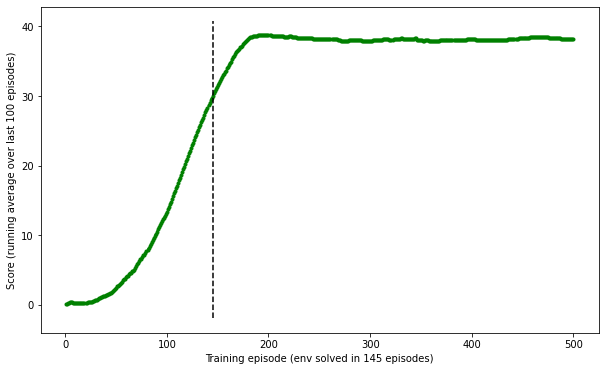

In [5]:
# Compute statistics
scores = all_avg_returns
num_episodes_to_solve_env = -1
solved_ep_idxes = np.where(np.array(scores) >= 30)
if len(solved_ep_idxes) > 0:
    num_episodes_to_solve_env = solved_ep_idxes[0][0] + 1  # +1 since ep_idx is 0-indexed

# Plot performance
plt.figure(figsize=(10,6), facecolor="white")
episodes = np.array(range(1, len(scores)+1))
plt.plot(episodes, scores, "g.:")
y_range = plt.ylim()
plt.plot((num_episodes_to_solve_env, num_episodes_to_solve_env), y_range, "k--")
plt.xlabel(f"Training episode (env solved in {num_episodes_to_solve_env} episodes)")
plt.ylabel("Score (running average over last 100 episodes)")
plt.savefig("training_curve.png")

In [8]:
# Evaluate saved DQN agent

# Look for presence of model checkpoints
actor_path = glob.glob("models/sac_actor_*.pt")[0]
critic_path = actor_path.replace("sac_actor_", "sac_critic_")

# Initialize agent and load model
agent = SAC(
    num_inputs=observation_size,
    action_space=action_space,
    hidden_size=hidden_size,
    lr=adam_learning_rate,
    gamma=gamma,
    tau=tau,
    alpha=initial_entropy,
    target_update_interval=target_update_interval,
    automatic_entropy_tuning=automatic_entropy_tuning
)
agent.load_model(actor_path, critic_path)

ep_pbar = tqdm.tqdm_notebook(range(eval_num_episodes), desc="Eval")
for ep_idx in ep_pbar:
    # Initialize variables
    score = 0
    done = False
    num_steps = 0
    sum_reward = 0

    # Reset environment
    state = np.squeeze(env.reset(train_mode=True)[brain_name].vector_observations)

    # Step loop
    while not done:
        action = agent.select_action(state, evaluate=True)
        env_info = env.step(action)[brain_name]
        state, reward, done = np.squeeze(env_info.vector_observations), np.squeeze(env_info.rewards), np.squeeze(env_info.local_done)

        # Update state and stats
        score += reward
        num_steps += 1
        sum_reward += reward
    
    ep_pbar.set_postfix(nStep=num_steps, score=score)
    print(f"Evaluated episode {ep_idx+1} / {eval_num_episodes}: score={score}, num_steps={num_steps}")


Loading models from models/sac_actor_reacher_2021-01-04_02-44-45.pt and models/sac_critic_reacher_2021-01-04_02-44-45.pt
ipykernel_launcher:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Eval:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluated episode 1 / 3: score=35.799999199807644, num_steps=1001
Evaluated episode 2 / 3: score=39.639999113976955, num_steps=1001
Evaluated episode 3 / 3: score=39.56999911554158, num_steps=1001


In [9]:
# Close environment
env.close()